## Introduction to Topic Modeling
  
Today we'll implement the most basic, and the original, topic modeling algorithm, LDA, using Python's scikit-learn. The other major topic modeling package is Gensim. 

Another option for topic modeling is the software MALLET. Check out this [blog post](https://de.dariah.eu/tatom/topic_model_mallet.html) to learn more about implementing MALLET.

### Learning Goals
* Implement a basic topic modeling algorithm and learn how to tweak it
* Learn how to use different methods to calculate topic prevalence
* Learn how to create some simple graphs with this output
* Think though how and why you might use topic modeling in a text analysis project

### Outline

(Side note: I'm demoing a clickable table of contents here. Give it a look to see how to do this in markdown.)

* [The Pandas Dataframe: Children's Literature](#df)
* [Fit an LDA Topic Model using scikit-learn](#fit)
* [Document by Topic Distribution](#dtd)
* [Words Aligned with each Topic](#words)
* [Topic Prevalence](#prev)
* [Topics Over Time](#time)


### Key Terms
* *Topic Modeling*:
    * A statistical model to uncover abstract topics within a text. It uses the co-occurrence fo words within documents, compared to their distribution across documents, to uncover these abstract themes. The output is a list of weighted words, which indicate the subject of each topic, and a weight distribution across topics for each document.
    
* *LDA*:
    * Latent Dirichlet Allocation. A implementation of topic modeling that assumes a Dirichlet prior. It does not take document order into account, unlike other topic modeling algorithms.
    
### Further Resources

[More detailed description of implementing LDA using scikit-learn](http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-topics-extraction-with-nmf-lda-py).

<a id='df'></a>
### 0. The Pandas Dataframe: Children's Literature

First, we read in a corpus of British Children's Literature, and transform it into a Pandas dataframe.

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
df_lit = pandas.read_csv("../data/childrens_lit.csv.bz2", sep='\t', index_col=0, encoding = 'utf-8', compression='bz2')

#drop rows where the text is missing.
df_lit = df_lit.dropna(subset=['text'])

#view the dataframe
df_lit.head()

,title,author gender,year,text
0,A Dog with a Bad Name,Male,1886,A DOG WITH A BAD NAME BY TALBOT BAINES REED ...
1,A Final Reckoning,Male,1887,A Final Reckoning: A Tale of Bush Life in Aust...
2,"A House Party, Don Gesualdo, and A Rainy June",Female,1887,A HOUSE-PARTY Don Gesualdo and A Rainy June...
3,A Houseful of Girls,Female,1889,"A HOUSEFUL OF GIRLS. BY SARAH TYTLER, AUTHOR ..."
4,A Little Country Girl,Female,1885,"LITTLE COUNTRY GIRL. BY SUSAN COOLIDGE, ..."


<a id='fit'></a>
### 1. Fit a Topic Model, using LDA

Now we're ready to fit the model. This requires the use of CountVecorizer, which we've already used, and the scikit-learn function LatentDirichletAllocation.

See [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) for more information about this function. 

In [3]:
####Adopted From: 
#Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

##This is a function to print out the top words for each topic in a pretty way.
#Don't worry too much about understanding every line of this code.
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [4]:
# Vectorize our text using CountVectorizer
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.80, min_df=50,
                                max_features=None,
                                stop_words='english'
                                )

tf = tf_vectorizer.fit_transform(df_lit.text)

Extracting tf features for LDA...


In [5]:
n_samples = 2000
n_topics = 4
n_top_words = 50

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_topics=%d..."
      % (n_samples, n_topics))



#define the lda function, with desired options
#Check the documentation, linked above, to look through the options
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=20,
                                learning_method='online',
                                learning_offset=80.,
                                total_samples=n_samples,
                                random_state=0)
#fit the model
lda.fit(tf)

Fitting LDA models with tf features, n_samples=2000 and n_topics=4...


LatentDirichletAllocation(learning_method='online', learning_offset=80.0,
                          max_iter=20, n_components=4, random_state=0,
                          total_samples=2000)

In [6]:
#print the top words per topic, using the function defined above.
#Unlike R, which has a built-in function to print top words, we have to write our own for scikit-learn
#I think this demonstrates the different aims of the two packages: R is for social scientists, Python for computer scientists

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:

Topic #0:
project doctor girls sister papa mamma london baby sweet tom street works dr remarked aunt tea youth foundation presently study em ain cousin office darling loved ladies wasn everybody public flower observed nurse ma shop snow ye queen class reader ice stairs flowers lovely agreement sisters doesn carriage bell garden

Topic #1:
dick uncle doctor er jack ain tom den yer fish em rock wolf gun rope lads ha birds rocks beneath ay stream shock tail moments mate excitedly garden eh sand fishing thrust ye nay gazing softly mountain ship tremendous hook bird leg ashore growled penny shore stones farther jump knife

Topic #2:
king army french troops camp attack officers prince ship john soldiers city village officer guns rode shore regiment march tom fort wounded british boats sword advanced castle jack james indian band marched native prisoners ships arrows france numbers lads forest frank ride presently vessel fought mounted fleet column stream rear

Topic #3

<a id='dtd'></a>
### 2. Document by Topic Distribution

One thing we may want to do with the output is find the most representative texts for each topic. A simple way to do this (but not memory efficient), is to merge the topic distribution back into the Pandas dataframe.

First get the topic distribution array.

In [7]:
topic_dist = lda.transform(tf)
topic_dist

array([[9.27993669e-01, 1.43700382e-02, 5.76027691e-02, 3.35234006e-05],
       [2.73383488e-02, 7.01313231e-02, 4.91328141e-01, 4.11202187e-01],
       [9.72301526e-01, 3.66126075e-05, 2.25981325e-02, 5.06372922e-03],
       [9.99907351e-01, 3.06661128e-05, 3.10550012e-05, 3.09277922e-05],
       [9.69292227e-01, 2.88828433e-02, 6.05477628e-05, 1.76438162e-03],
       [9.02818435e-01, 9.70583246e-02, 6.16743414e-05, 6.15656757e-05],
       [4.10396600e-01, 5.86307314e-01, 1.35979768e-04, 3.16010688e-03],
       [9.99890902e-01, 3.60980543e-05, 3.67128035e-05, 3.62872482e-05],
       [2.46371338e-01, 2.56589766e-01, 4.50088248e-01, 4.69506480e-02],
       [7.08481800e-05, 3.81086663e-01, 6.18771825e-01, 7.06641686e-05],
       [6.19417246e-02, 5.60865999e-02, 8.81890242e-01, 8.14334923e-05],
       [5.50253267e-05, 5.59319821e-05, 5.52375701e-05, 9.99833805e-01],
       [1.54941895e-01, 8.53067338e-05, 1.95440934e-01, 6.49531864e-01],
       [8.16413872e-01, 6.08089939e-02, 1.22708631e

Merge back in with the original dataframe.

In [8]:
topic_dist_df = pandas.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(df_lit)
df_w_topics

,0,1,2,3,title,author gender,year,text
0,0.927994,0.014370,0.057603,0.000034,A Dog with a Bad Name,Male,1886.0,A DOG WITH A BAD NAME BY TALBOT BAINES REED ...
1,0.027338,0.070131,0.491328,0.411202,A Final Reckoning,Male,1887.0,A Final Reckoning: A Tale of Bush Life in Aust...
2,0.972302,0.000037,0.022598,0.005064,"A House Party, Don Gesualdo, and A Rainy June",Female,1887.0,A HOUSE-PARTY Don Gesualdo and A Rainy June...
3,0.999907,0.000031,0.000031,0.000031,A Houseful of Girls,Female,1889.0,"A HOUSEFUL OF GIRLS. BY SARAH TYTLER, AUTHOR ..."
4,0.969292,0.028883,0.000061,0.001764,A Little Country Girl,Female,1885.0,"LITTLE COUNTRY GIRL. BY SUSAN COOLIDGE, ..."
...,...,...,...,...,...,...,...,...
122,0.000047,0.000047,0.000048,0.999858,Treasure Island,Male,1883.0,TREASURE ISLAND by Robert Louis Stevenson ...
123,0.960205,0.000054,0.005191,0.034551,Twice Bought,Male,1885.0,"The Project Gutenberg EBook of Twice Bought, b..."
124,0.000026,0.000025,0.999923,0.000026,Two Arrows,Male,1886.0,TWO ARROWS HARPER'S YOUNG PEOPLE'S SERIES...
125,0.000020,0.000020,0.999940,0.000020,Uncle Remus: His Songs and Sayings,Male,1880.0,Uncle Remus: His Songs and His Sayings By Joe...


Now we can sort the dataframe for the topic of interest, and view the top documents for the topics.
Below we sort the documents first by Topic 0 (looking at the top words for this topic I think it's about family, health, and domestic activities), and next by Topic 1 (again looking at the top words I think this topic is about children playing outside in nature). These topics may be a family/nature split?

Look at the titles for the two different topics. Look at the gender of the author. Hypotheses?

In [9]:
print(df_w_topics[['title', 'author gender', 0]].sort_values(by=[0], ascending=False))

                                  title author gender         0
85                                  NaN           NaN  0.999914
3                   A Houseful of Girls        Female  0.999907
97                   The Life of a Ship          Male  0.999903
100   The Little Princess of Tower Hill        Female  0.999898
7                      A World of Girls        Female  0.999891
..                                  ...           ...       ...
24                     Dick o' the Fens          Male  0.000022
111                The Thorogood Family          Male  0.000021
33                       For the Temple          Male  0.000021
125  Uncle Remus: His Songs and Sayings          Male  0.000020
49                            Menhardoc          Male  0.000019

[127 rows x 3 columns]


In [10]:
print(df_w_topics[['title', 'author gender', 1]].sort_values(by=[1], ascending=False))

                                  title author gender         1
24                     Dick o' the Fens          Male  0.999933
53                      My Friend Smith          Male  0.999922
19                          Bunyip Land          Male  0.999919
48               Little Lord Fauntleroy        Female  0.999916
114             The Willoughby Captains          Male  0.999896
..                                  ...           ...       ...
126                  Under Drake's Flag          Male  0.000022
111                The Thorogood Family          Male  0.000021
33                       For the Temple          Male  0.000021
76                        The Big Otter          Male  0.000021
125  Uncle Remus: His Songs and Sayings          Male  0.000020

[127 rows x 3 columns]


<a id='words'></a>
### 3. Words Aligned with each Topic

We can calculate the total number of words aligned with each topic, and compare by author gender.

In [11]:
#first create word count column

df_w_topics['word_count'] = df_w_topics['text'].apply(lambda x: len(str(x).split()))
df_w_topics['word_count']

0       96493
1      100603
2       85132
3       92822
4       48251
        ...  
122     68589
123     76593
124     56018
125     53942
126    108275
Name: word_count, Length: 127, dtype: int64

In [12]:
#multiple topic weight by word count

df_w_topics['0_wc'] = df_w_topics[0] * df_w_topics['word_count']
df_w_topics['0_wc']

0      89544.893129
1       2750.319905
2      82773.973483
3      92813.400143
4      46769.319262
           ...     
122        3.232002
123    73544.948175
124        1.447412
125        1.081305
126        2.422885
Name: 0_wc, Length: 127, dtype: float64

In [13]:
#create a for loop to do this for every topic
topic_columns = range(0, n_topics)
col_list = []
for num in topic_columns:
    col = "%d_wc" % num
    col_list.append(col)
    #Solution
    df_w_topics[col] = df_w_topics[num] * df_w_topics['word_count']
    
df_w_topics.head()

,0,1,2,3,title,author gender,year,text,word_count,0_wc,1_wc,2_wc,3_wc
0,0.927994,0.014370,0.057603,0.000034,A Dog with a Bad Name,Male,1886.0,A DOG WITH A BAD NAME BY TALBOT BAINES REED ...,96493,89544.893129,1386.608095,5558.264002,3.234773
1,0.027338,0.070131,0.491328,0.411202,A Final Reckoning,Male,1887.0,A Final Reckoning: A Tale of Bush Life in Aust...,100603,2750.319905,7055.421499,49429.084933,41368.173663
2,0.972302,0.000037,0.022598,0.005064,"A House Party, Don Gesualdo, and A Rainy June",Female,1887.0,A HOUSE-PARTY Don Gesualdo and A Rainy June...,85132,82773.973483,3.116905,1923.824216,431.085396
3,0.999907,0.000031,0.000031,0.000031,A Houseful of Girls,Female,1889.0,"A HOUSEFUL OF GIRLS. BY SARAH TYTLER, AUTHOR ...",92822,92813.400143,2.846490,2.882587,2.870780
4,0.969292,0.028883,0.000061,0.001764,A Little Country Girl,Female,1885.0,"LITTLE COUNTRY GIRL. BY SUSAN COOLIDGE, ...",48251,46769.319262,1393.626070,2.921490,85.133178


<a id='time'></a>
### 4. Topic Prevalence over time

We can do the same as above, but by year, to graph the prevalence of each topic over time.

In [14]:
grouped_year = df_w_topics[['0_wc', '1_wc', '2_wc', '3_wc', 'year']].groupby('year').mean()
grouped_year

,0_wc,1_wc,2_wc,3_wc
year,,,,
1880.0,15794.201049,38005.446648,10041.439549,7977.162754
1881.0,31449.685887,7819.022251,31735.941554,11839.350308
1882.0,31981.062589,15605.106999,3464.397757,19884.099322
1883.0,16343.271990,17545.803370,27460.460085,8770.254029
1884.0,40760.187888,8588.532149,15938.370179,4661.409784
1885.0,25531.289505,25119.637127,11866.668736,13221.154632
1886.0,37580.788620,17129.076190,18723.589440,5997.722220
1887.0,34624.013800,5714.306037,18226.965877,17118.114287
1888.0,31871.601433,10618.490345,31105.366516,1701.157091


<AxesSubplot:xlabel='year', ylabel='0_wc'>

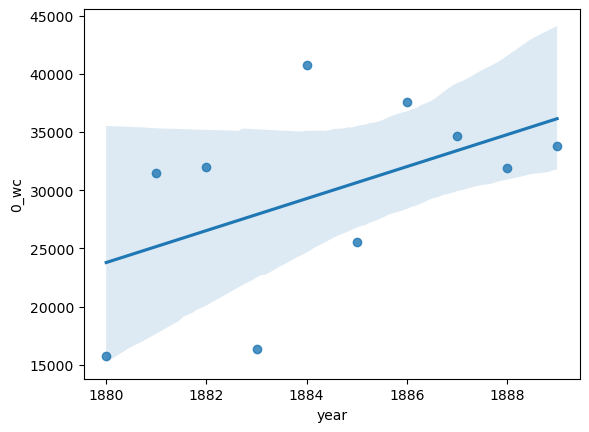

In [15]:
import seaborn as sns

sns.regplot(x=grouped_year.index, y = '0_wc', data = grouped_year)

<AxesSubplot:xlabel='year', ylabel='1_wc'>

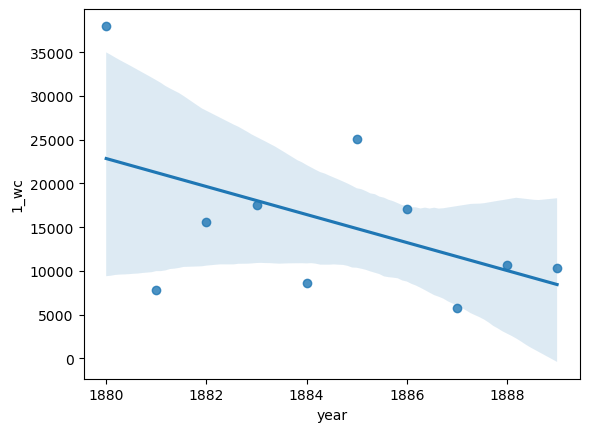

In [16]:
sns.regplot(x=grouped_year.index, y = '1_wc', data = grouped_year)

In [17]:
# Remember what these two topics are:

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:

Topic #0:
project doctor girls sister papa mamma london baby sweet tom street works dr remarked aunt tea youth foundation presently study em ain cousin office darling loved ladies wasn everybody public flower observed nurse ma shop snow ye queen class reader ice stairs flowers lovely agreement sisters doesn carriage bell garden

Topic #1:
dick uncle doctor er jack ain tom den yer fish em rock wolf gun rope lads ha birds rocks beneath ay stream shock tail moments mate excitedly garden eh sand fishing thrust ye nay gazing softly mountain ship tremendous hook bird leg ashore growled penny shore stones farther jump knife

Topic #2:
king army french troops camp attack officers prince ship john soldiers city village officer guns rode shore regiment march tom fort wounded british boats sword advanced castle jack james indian band marched native prisoners ships arrows france numbers lads forest frank ride presently vessel fought mounted fleet column stream rear

Topic #3

# Exercises!

1. Fit a new topic model, lda_new, and change some of the parameters. How does this change the output?
Suggestions for what to change:
* Change the number of topics. 
* Do not remove stop words. 
* Change other options, either in the vectorize stage or the LDA model.

2. In our original model, find the most prevalent topic in the corpus. Find the least prevalent topic in the corpus. 
 
3. What is the total number of words aligned with each topic, by author gender?

4. What is the proportion of total words aligned with each topic, by author gender?

5. What is the average topic weight by author gender, for each topic?

6. Grapth any of the above results.

7. Visualize the other two topics over time. Do you find anything interesting?



In [ ]:
# 1. Fit a new topic model, lda_new, and change some of the parameters. How does this change the output?

lda_new = LatentDirichletAllocation(n_components=10, max_iter=20,
                                learning_method='online',
                                learning_offset=80.,
                                total_samples=n_samples,
                                random_state=0)
#fit the model
lda_new.fit(tf)

print("\nTopics in LDA model:")
tf_feature_names_new = tf_vectorizer.get_feature_names_out()
print_top_words(lda_new, tf_feature_names_new, 20)

In [ ]:
# In our original model, find the most prevalent topic in the corpus. 
# Find the least prevalent topic in the corpus.

for e in col_list:
    print(e)
    print(df_w_topics[e].sum()/df_w_topics['word_count'].sum())

In [ ]:
# 3. What is the total number of words aligned with each topic, by author gender?

grouped_sum=df_w_topics.groupby('author gender').sum()
grouped_sum[['0_wc','1_wc','2_wc','3_wc']].plot(kind='bar')
plt.show()

In [ ]:
# 4. What is the proportion of total words aligned with each topic, by author gender?

grouped_mean=df_w_topics.groupby('author gender').mean()
grouped_mean[['0_wc','1_wc','2_wc','3_wc']].plot(kind='bar')
plt.show()

In [ ]:
# 5. What is the average topic weight by author gender, for each topic?

grouped_mean=df_w_topics.groupby('author gender').mean()
grouped_mean[[0,1,2,3]].plot(kind='bar')
plt.show()

In [ ]:
#  7. Visualize the other two topics over time. Do you find anything interesting?
sns.regplot(x=grouped_year.index, y = '2_wc', data = grouped_year)

In [ ]:
sns.regplot(x=grouped_year.index, y = '3_wc', data = grouped_year)